In [1]:
# 0. INIT

In [2]:
!pip3 install matplotlib pandas plotly croniter numpy


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import tkinter
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from croniter import croniter
import numpy as np
import os
import pytz

# matplotlib.use('TkAgg')

In [4]:
#############################################################
# 1. INPUT CLIENT NAME AND REGION HERE
#############################################################

In [5]:
CLIENT_NAME = "ciaa"
REGION = "au"

ALL_CLIENTS_SCHEDULE_PATH = "csv/ALL_CLIENTS_schedules.csv"

In [6]:
#############################################################
# 2. UTILS
#############################################################

In [7]:
def filter_schedule(s, client):
    s = s[s["client"]==client]
    return s

def convert_time_melbourne_to_cali(hour, minute):
    # Define time zones
    melbourne_timezone = pytz.timezone('Australia/Sydney')
    california_timezone = pytz.timezone('America/Los_Angeles')

    # Get today's date
    today = datetime.now().date()

    # Create a datetime object for the input time in Melbourne
    melbourne_time = datetime(today.year, today.month, today.day, hour, minute)

    # Localize Melbourne time to its time zone
    melbourne_time = melbourne_timezone.localize(melbourne_time)

    # Convert Melbourne time to California time
    california_time = melbourne_time.astimezone(california_timezone)

    # Extract hour and minute in California time
    california_hour = california_time.hour
    california_minute = california_time.minute

    return california_hour, california_minute
    
def parse_cron_expression(cron_expr):
    # Split the cron expression into parts
    parts = cron_expr.split()
    
    # Define the labels for each part of the cron expression
    labels = ["seconds", "minutes", "hours", "day_of_the_month", "month", "day_of_the_week"]
    
    # Check if the expression includes the optional Year part
    if len(parts) == 7:
        labels.append("year_optional")
    
    # Create a dictionary to hold the parsed parts
    cron_parts = {}
    
    # Populate the dictionary with the parts
    for label, part in zip(labels, parts):
        cron_parts[label] = part
    
    return cron_parts

def generate_per_client_schedule(client_schedules):
    custom_order = ["run_report",
                    "contact_conversion",
                    "load_dataset", 
                    "run_dataflow", 
                    "unification_job", 
                    "run_enrichment", 
                    "build_features", 
                    "build_index"]
    client_schedules['job_type'] = pd.Categorical(client_schedules['job_type'], 
                                                  categories=custom_order, ordered=True)
    sorted_df = client_schedules.sort_values(by='job_type')
    
    # Save file if not available
    file_path = f"csv/{CLIENT_NAME}_schedules.csv"
    if not os.path.exists(file_path):
        sorted_df.to_csv(file_path, index=False)
        print(f'DataFrame successfully saved to {file_path}')
    else:
        print(f'The file {file_path} already exists. The DataFrame was not saved.')

In [8]:
def plot_crons_and_hours_circle(client_schedules, title):
    type_colors = {"load_dataset": "green",
                   "contact_conversion": "green",
                   "run_dataflow": "orange",
                   "run_enrichment": "purple",
                   "build_features": "blue",
                   "unification_job": "cyan",
                   "run_report": "magenta",
                   "build_index": "red"}
    
    # Initialize plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plotting a circle representing 24 hours
    circle = plt.Circle((0.5, 0.5), 0.4, color='gray', fill=False)
    ax.add_artist(circle)
    
    # Plot each hour mark on the circle with a square marker
    hours = np.arange(0, 24)
    angles = np.deg2rad(90 - hours * 360 / 24)
    
    # Plot points for hours with a square marker
    ax.scatter(0.5 + 0.4 * np.cos(angles), 0.5 + 0.4 * np.sin(angles), s=5, color='blue', marker='s')
    
    # Label hours
    for hour, angle in zip(hours, angles):
        ax.text(0.5 + 0.45 * np.cos(angle), 0.5 + 0.45 * np.sin(angle), str(hour), ha='center', va='center', fontsize=10)
    
    # Plot each cron expression
    for c in client_schedules:
        # Convert time between AU and US depending on the region
        if REGION == "us":
            hours, minutes = convert_time_melbourne_to_cali(int(c["hours"]), int(c["minutes"]))
        else:
            hours, minutes = int(c["hours"]), int(c["minutes"])
        angles = np.deg2rad(90 - (hours + minutes / 60) * 360 / 24)
        
        # Plot points for cron expression on the circle
        rotation_angle = np.degrees(angles)
        if 0 <= rotation_angle <= 180:
            rotation_angle = rotation_angle
        else:
            rotation_angle = rotation_angle + 180

        # Plot job name
        service_name = '_'.join(c["service_name"].split('_')[1:])
        ax.scatter(0.5 + 0.4 * np.cos(angles), 0.5 + 0.4 * np.sin(angles), label=c["job_type"], color=type_colors[c["job_type"]])
        ax.text(0.5 + 0.4 * np.cos(angles), 0.5 + 0.4 * np.sin(angles), str(service_name), 
                ha='center', va='center', fontsize=7, 
                rotation=rotation_angle,
                color = type_colors[c["job_type"]])
    
    # Set plot parameters
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Manually create legend handles
    handles = []
    labels = []
    for job_type, color in type_colors.items():
        handles.append(plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10))
        labels.append(job_type)
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Show plot
    plt.show()


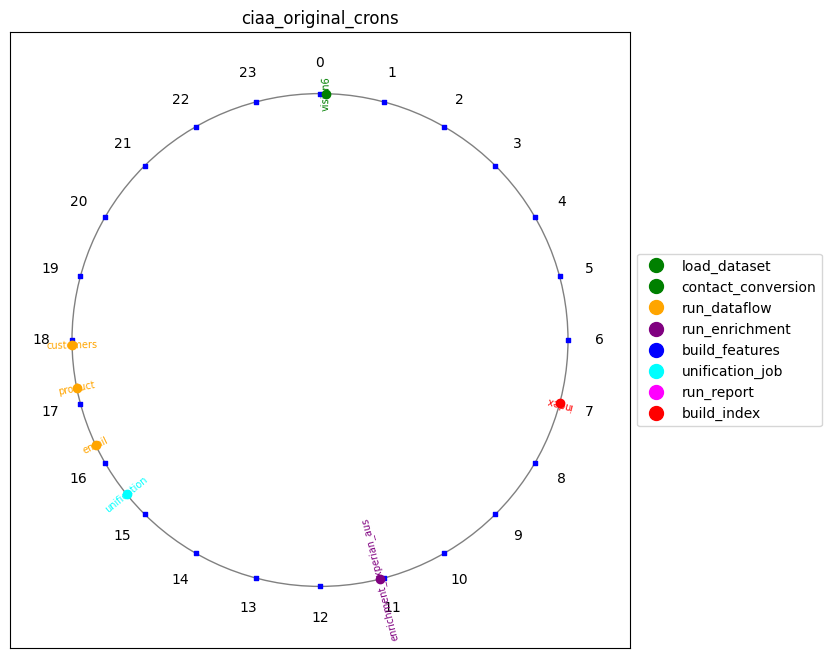

The file csv/ciaa_schedules.csv already exists. The DataFrame was not saved.


/var/folders/jt/xckbkrbd6qnckk24tnyx824m0000gp/T/ipykernel_25760/2798081814.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_schedules['job_type'] = pd.Categorical(client_schedules['job_type'],


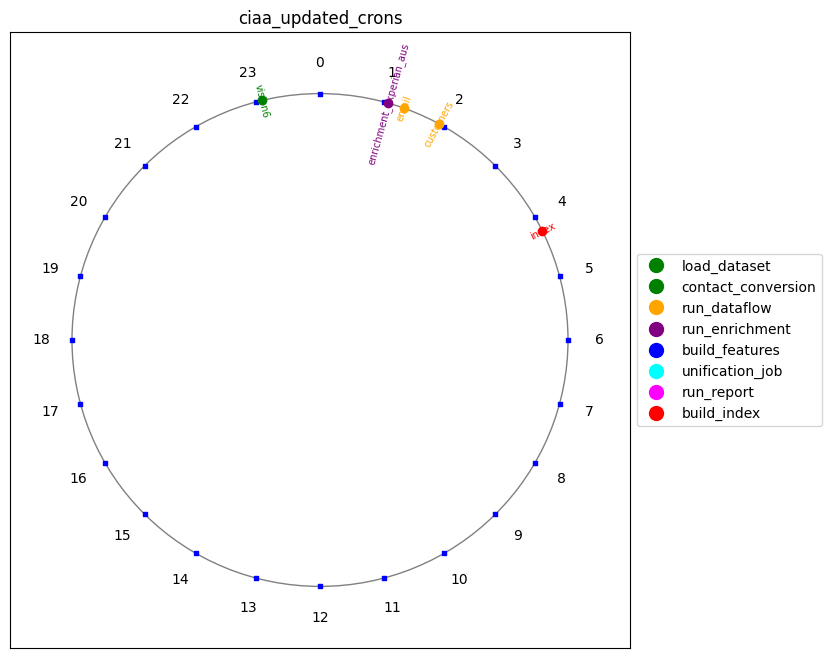

In [9]:
#############################################################
# 3. PLOT CRONS
#############################################################
# ORIGINAL SCHEDULE
# Grab from big file "schedules.csv"
schedules = pd.read_csv(ALL_CLIENTS_SCHEDULE_PATH)
client_schedules = filter_schedule(schedules, CLIENT_NAME)
plot_crons_and_hours_circle(client_schedules.to_dict(orient='records'), f"{CLIENT_NAME}_original_crons")

# UPDATED SCHEDULE
# Grab from individual client file "/clients/{CLIENT_NAME}_schedules.csv"
# Automatically create the file if it does not exist
generate_per_client_schedule(client_schedules)
updated_schedules = pd.read_csv(f"csv/{CLIENT_NAME}_schedules.csv")
plot_crons_and_hours_circle(updated_schedules.to_dict(orient='records'), f"{CLIENT_NAME}_updated_crons")